In [4]:
class SmaCrossStrategy(bt.Strategy):
    params = dict(
        sma_short_period=10,
        sma_long_period=50,
    )

    def __init__(self):
        self.sma_short = bt.ind.SMA(period=self.p.sma_short_period)
        self.sma_long = bt.ind.SMA(period=self.p.sma_long_period)
        self.crossover = bt.ind.CrossOver(self.sma_short, self.sma_long)

    def next(self):
        if not self.position:
            if self.crossover > 0:
                self.buy()
        elif self.crossover < 0:
            self.sell()

In [5]:
import backtrader as bt
import yfinance as yf
import pandas as pd

data = yf.download('TSLA', start='2024-06-01', end='2025-02-13')
# Flatten the MultiIndex columns by taking their first level
data.columns = [col[0] for col in data.columns]
# Select columns required by Backtrader and convert them to lowercase
data = data[['Open', 'High', 'Low', 'Close', 'Volume']]
data.columns = [col.lower() for col in data.columns]
data_bt = bt.feeds.PandasData(dataname=data)

[*********************100%***********************]  1 of 1 completed


In [6]:
cerebro = bt.Cerebro()
cerebro.addstrategy(SmaCrossStrategy)
cerebro.adddata(data_bt)
cerebro.broker.set_cash(100000.0)
cerebro.broker.setcommission(commission=0.001)  # handling fee to 0.1%
cerebro.broker.set_slippage_perc(0.001)      # slippage to 0.1%  
cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name='sharpe')
cerebro.addanalyzer(bt.analyzers.DrawDown, _name='drawdown') 
cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name='trade_analyzer')
cerebro.run()


In [7]:
# Print out the final result
results = cerebro.run()
sharpe = results[0].analyzers.sharpe.get_analysis()
drawdown = results[0].analyzers.drawdown.get_analysis()
trade_analyzer = results[0].analyzers.trade_analyzer.get_analysis()

print(f"Final net asset value: {cerebro.broker.getvalue():.2f}")
print(f"Sharpe Ratio: {sharpe['sharperatio']:.2f}")
print(f"Maximum drawdown: {drawdown.max.drawdown:.2f}%")
print(f"Total trade times: {trade_analyzer.total.closed}")

Final net asset value: 100108.02
Sharpe Ratio: -13.30
Maximum drawdown: 0.10%
Total trade times: 2


In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
cerebro.plot(iplot = False)

[[<Figure size 640x480 with 5 Axes>]]

In [9]:
class MomentumStrategy(bt.Strategy):
    # Define the strategy parameters; here 'period' is the lookback period for the momentum indicator
    params = (('period', 10),)

    def __init__(self):
        # Create a Momentum indicator using the close prices with the defined period
        self.momentum = bt.indicators.Momentum(self.data.close, period=self.params.period)
        # Store initial portfolio value to compare performance later
        self.starting_value = self.broker.getvalue()
        # List to record the portfolio value at each step for performance analysis
        self.daily_values = []

    def next(self):
        # If no position is currently held, consider entering the market
        if not self.position:
            # Go long if the momentum indicator suggests upward momentum
            if self.momentum[0] > 0:
                self.buy()
        # If already in a position, exit if momentum turns non-positive
        elif self.momentum[0] <= 0:
            self.sell()

        # Append the current portfolio value to track daily performance
        self.daily_values.append(self.broker.getvalue())

In [10]:
import pandas as pd
import numpy as np
cerebro = bt.Cerebro()
cerebro.addstrategy(MomentumStrategy)

cerebro.adddata(data_bt)

cerebro.broker.setcash(100000)

print(f'Initial capital: {cerebro.broker.getvalue():.2f}')
results = cerebro.run()
print(f'Funds after backtesting: {cerebro.broker.getvalue():.2f}')

strategy = results[0]

portfolio_values = pd.Series(strategy.daily_values)
returns = portfolio_values.pct_change().dropna()

annual_return = returns.mean() * 252
annual_volatility = returns.std() * np.sqrt(252)
risk_free_rate = 0.01 
sharpe_ratio = (annual_return - risk_free_rate) / annual_volatility

cumulative_returns = (1 + returns).cumprod()
drawdown = cumulative_returns / cumulative_returns.cummax() - 1
max_drawdown = drawdown.min()

print(f'Sharpe Ratio: {sharpe_ratio:.2f}')
print(f'Max drawdown: {max_drawdown:.2%}')


Initial capital: 100000.00
Funds after backtesting: 100192.08
Sharpe Ratio: -4.55
Max drawdown: -0.08%


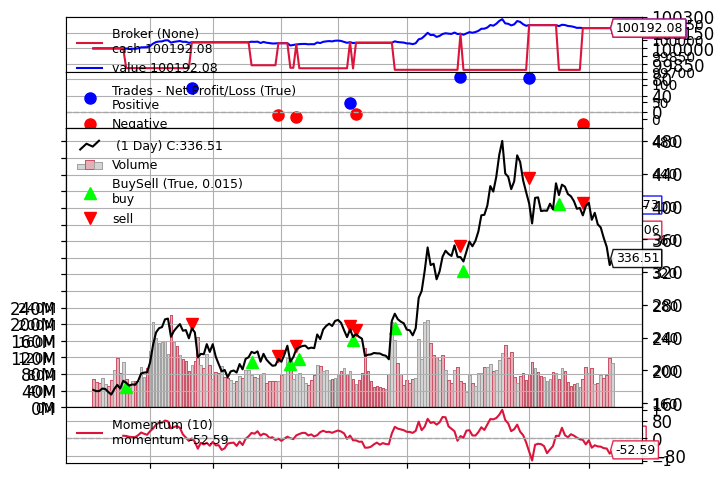

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [15, 12]
plt.rcParams.update({'font.size': 12})
img = cerebro.plot(iplot = False)

In [26]:
class MeanReversionStrategy(bt.Strategy):
    params = (('period', 20), ('zscore_entry', 1), ('zscore_exit', 0))

    def __init__(self):
        self.moving_avg = bt.indicators.SimpleMovingAverage(self.data.close, period=self.params.period)
        self.stddev = bt.indicators.StandardDeviation(self.data.close, period=self.params.period)
        self.zscore = None
        self.daily_values = []

    def next(self):
        # Ensure there are enough data points to calculate zscore
        if len(self.data) >= self.params.period:
            # Calculate z-score
            self.zscore = (self.data.close[0] - self.moving_avg[0]) / (self.stddev[0] + 1e-8)  # Add a small value to avoid division by zero

            # If no position is currently held, consider entering the market
            if not self.position:
                # Go long if the zscore is below the entry threshold
                if self.zscore < -self.params.zscore_entry:
                    self.buy()
            # If already in a position, exit if zscore crosses the exit threshold
            elif self.zscore >= self.params.zscore_exit:
                self.sell()

        # Append the current portfolio value to track daily performance
        self.daily_values.append(self.broker.getvalue())

cerebro = bt.Cerebro()
cerebro.addstrategy(MeanReversionStrategy)

cerebro.adddata(data_bt)

cerebro.broker.setcash(100000)

print(f'Initial capital: {cerebro.broker.getvalue():.2f}')
results = cerebro.run()
print(f'Funds after backtesting: {cerebro.broker.getvalue():.2f}')

strategy = results[0]

portfolio_values = pd.Series(strategy.daily_values)
returns = portfolio_values.pct_change().dropna()

annual_return = returns.mean() * 252
annual_volatility = returns.std() * np.sqrt(252)
risk_free_rate = 0.01  # Risk-free rate set to 1%
sharpe_ratio = (annual_return - risk_free_rate) / annual_volatility

# Calculate maximum drawdown
cumulative_returns = (1 + returns).cumprod()
drawdown = cumulative_returns / cumulative_returns.cummax() - 1
max_drawdown = drawdown.min()

print(f'Sharpe Ratio: {sharpe_ratio:.2f}')
print(f'Max drawdown: {max_drawdown:.2%}')


Initial capital: 100000.00
Funds after backtesting: 100003.89
Sharpe Ratio: -9.03
Max drawdown: -0.09%


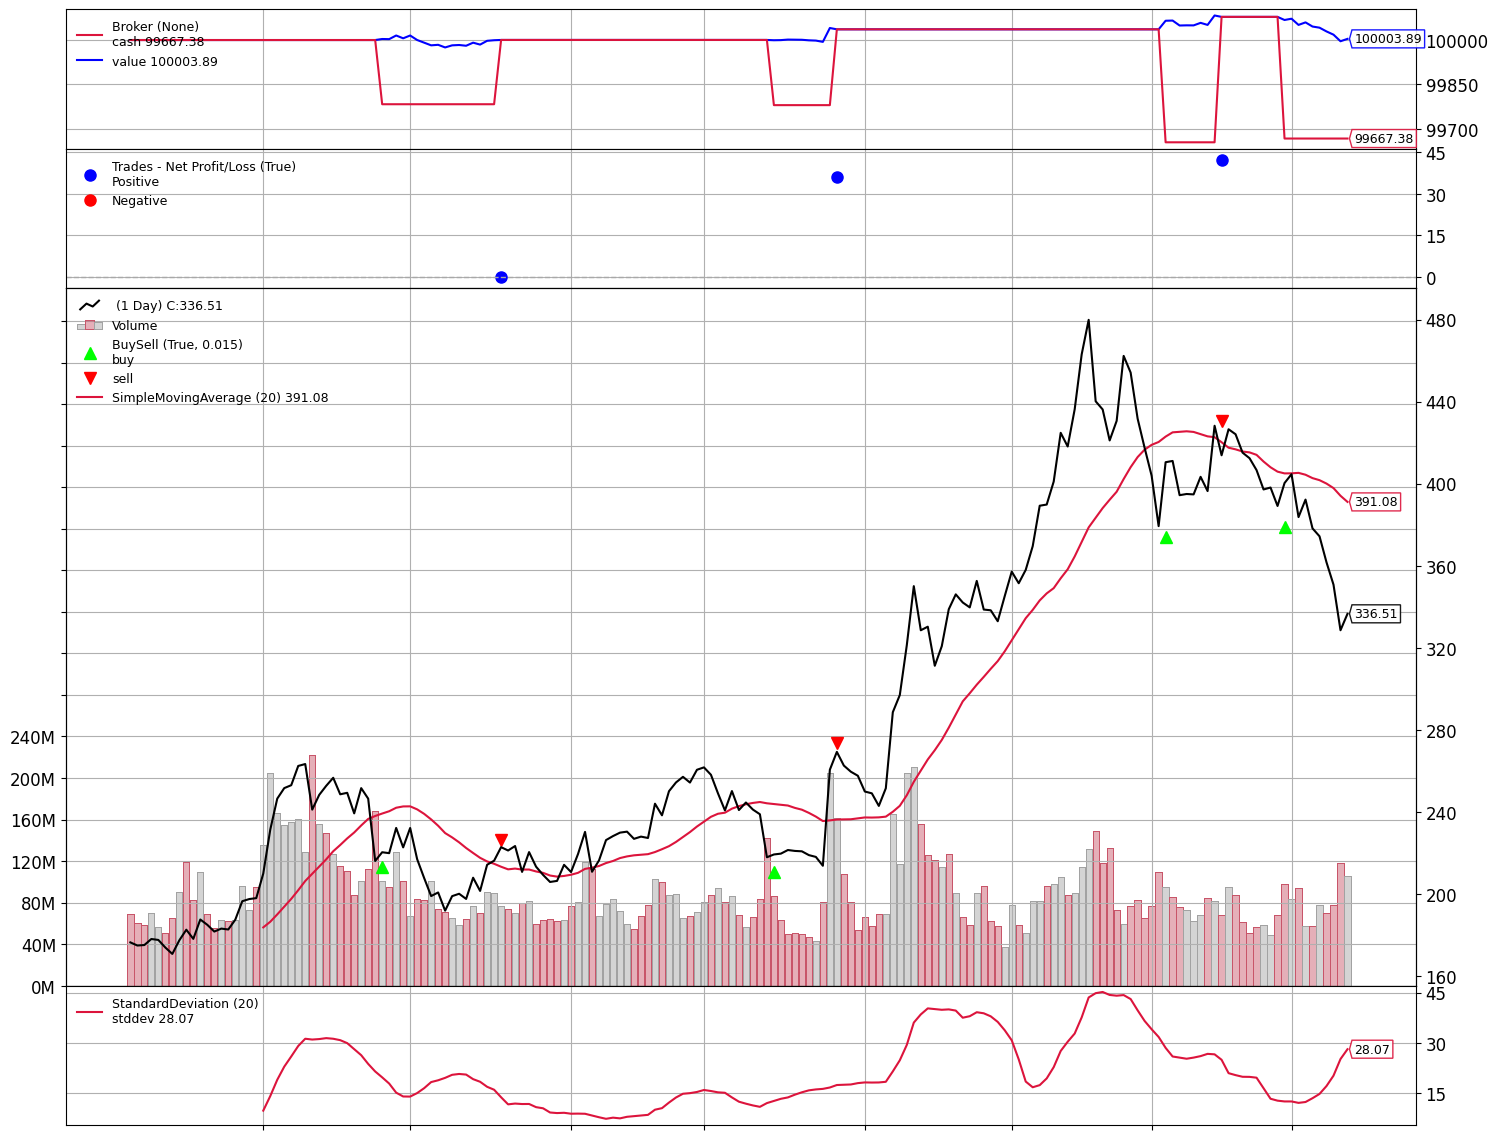

In [27]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [15, 12]
plt.rcParams.update({'font.size': 12})
img = cerebro.plot(iplot = False)

In [ ]:
class RSIStrategy(bt.Strategy):
    params = (('rsi_period', 14), ('rsi_overbought', 70), ('rsi_oversold', 30))

    def __init__(self):
        self.rsi = bt.indicators.RelativeStrengthIndex(self.data.close, period=self.params.rsi_period)
        self.daily_values = []  # Used to store daily asset values

    def next(self):
        if self.rsi < self.params.rsi_oversold and not self.position:
            self.buy()
        elif self.rsi > self.params.rsi_overbought and self.position:
            self.sell()

        # Record the asset value of the day at each update
        self.daily_values.append(self.broker.getvalue())

# Set up the backtesting environment
cerebro = bt.Cerebro()
cerebro.addstrategy(RSIStrategy)

cerebro.adddata(data_bt)

cerebro.broker.setcash(100000)

print(f'Initial capital: {cerebro.broker.getvalue():.2f}')
results = cerebro.run()
print(f'Funds after backtesting: {cerebro.broker.getvalue():.2f}')

strategy = results[0]

# Calculate daily returns
portfolio_values = pd.Series(strategy.daily_values)
returns = portfolio_values.pct_change().dropna()

# Calculate annualized Sharpe ratio
annual_return = returns.mean() * 252
annual_volatility = returns.std() * np.sqrt(252)
risk_free_rate = 0.01  # Risk-free rate set to 1%

# Check if annual_volatility is zero to avoid division by zero
if annual_volatility != 0:
    sharpe_ratio = (annual_return - risk_free_rate) / annual_volatility
else:
    sharpe_ratio = float('inf') if annual_return > risk_free_rate else float('-inf')

# Calculate maximum drawdown
cumulative_returns = (1 + returns).cumprod()
drawdown = cumulative_returns / cumulative_returns.cummax() - 1
max_drawdown = drawdown.min()

print(f'Sharpe Ratio: {sharpe_ratio:.2f}')
print(f'Max drawdown: {max_drawdown:.2%}')

Initial capital: 100000.00
Funds after backtesting: 100000.00
Sharpe Ratio: -inf
Max drawdown: 0.00%


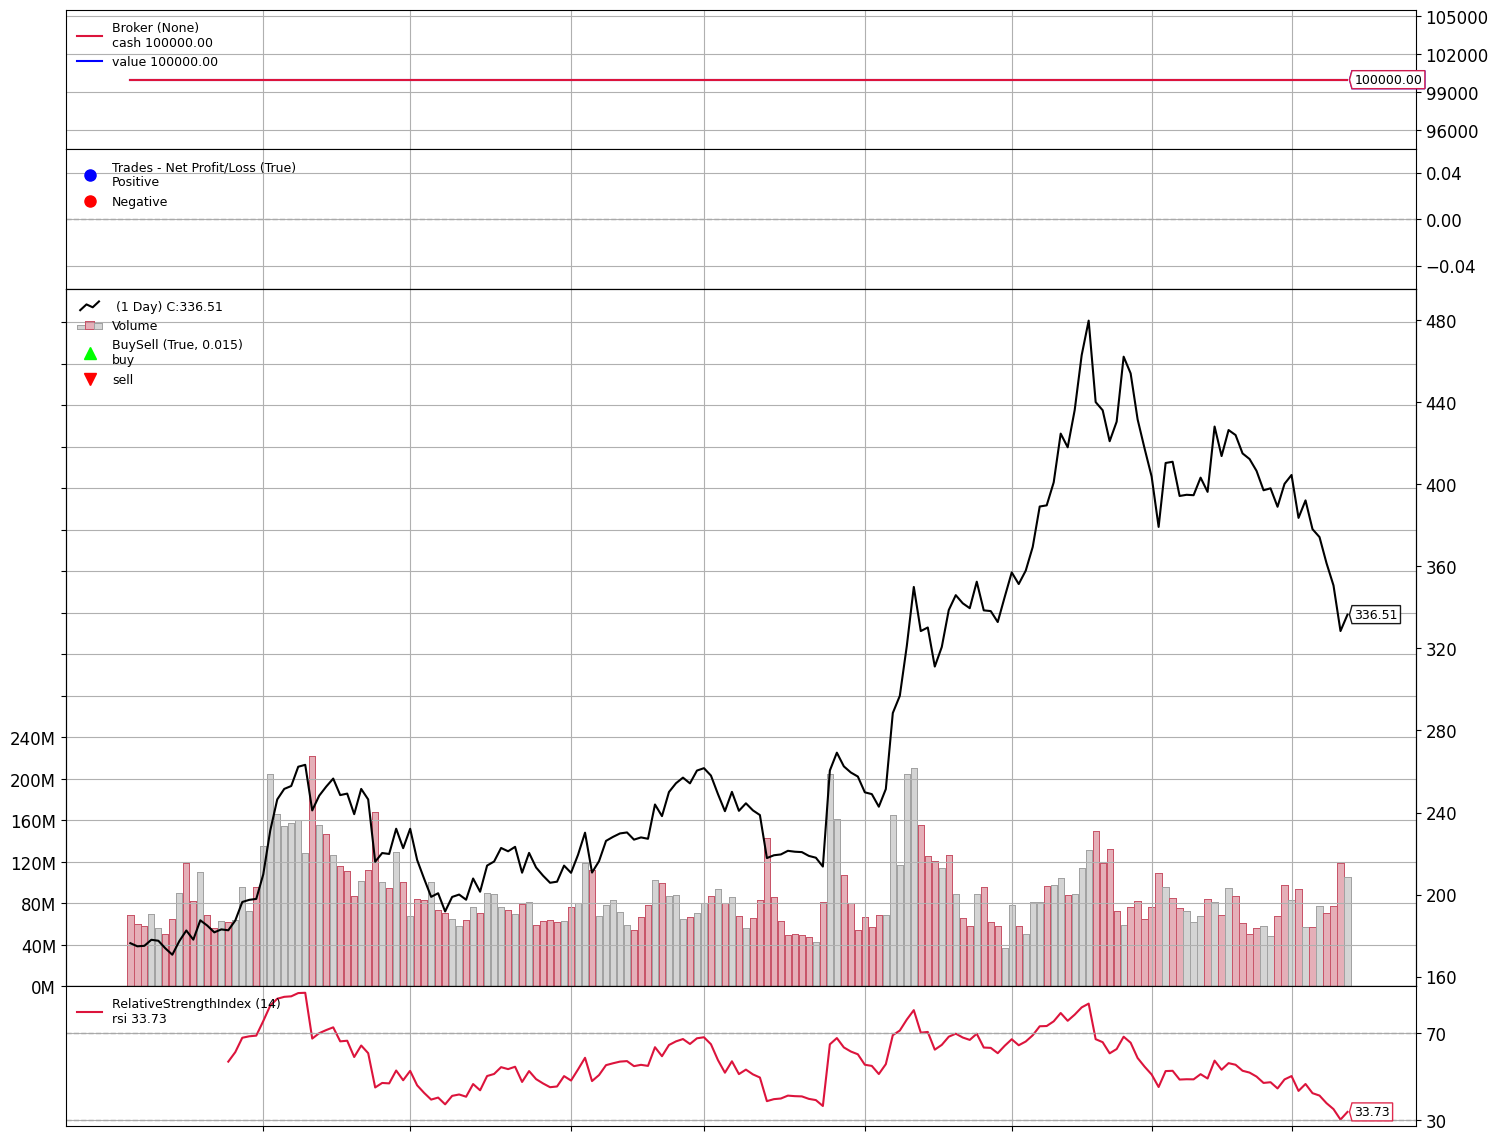

In [22]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [15, 12]
plt.rcParams.update({'font.size': 12})
img = cerebro.plot(iplot = False)

In [28]:
import backtrader as bt
import backtrader.analyzers as btanalyzers
import pandas as pd
from datetime import datetime
import yfinance as yf 

In [29]:
class MaCrossStrategy(bt.Strategy):
    params = (
        ('fast_length', 10),
        ('slow_length', 50)
    )
    
    def __init__(self):
        ma_fast = bt.ind.SMA(period=self.params.fast_length)
        ma_slow = bt.ind.SMA(period=self.params.slow_length)
        
        self.crossover = bt.ind.CrossOver(ma_fast, ma_slow)

    def next(self):
        if not self.position:
            if self.crossover > 0:
                self.buy()
        elif self.crossover < 0:
            self.close()

In [41]:
cerebro = bt.Cerebro()

import yfinance as yf

data = yf.download('AAPL', start='2024-01-01', end='2025-02-17', auto_adjust=False)

# Flatten the MultiIndex columns by taking their first level
data.columns = [col[0] for col in data.columns]
# Select columns required by Backtrader and convert them to lowercase
data = data[['Open', 'High', 'Low', 'Close', 'Volume']]
data.columns = [col.lower() for col in data.columns]

data_bt = bt.feeds.PandasData(dataname=data)

cerebro.adddata(data_bt)

# 設定策略參數範圍
strats = cerebro.optstrategy(
    MaCrossStrategy,
    fast_length=range(1, 11),
    slow_length=range(25, 76, 5)
)

# 設定初始資金與分析工具
cerebro.broker.setcash(1000000.0)
cerebro.addsizer(bt.sizers.PercentSizer, percents=10)
cerebro.addanalyzer(btanalyzers.SharpeRatio, _name="sharpe", timeframe=bt.TimeFrame.Days, annualize=True)
cerebro.addanalyzer(btanalyzers.DrawDown, _name="drawdown")
cerebro.addanalyzer(btanalyzers.Returns, _name="returns")

# 執行回測
back = cerebro.run(maxcpus=1)


[*********************100%***********************]  1 of 1 completed


In [42]:
par_list = []
for run in back:
    for strategy in run:
        sharpe_ratio = strategy.analyzers.sharpe.get_analysis().get('sharperatio')
        returns = strategy.analyzers.returns.get_analysis().get('rnorm100')
        drawdown = strategy.analyzers.drawdown.get_analysis().get('max', {}).get('drawdown')
        
        if sharpe_ratio is not None:
            par_list.append([
                strategy.params.fast_length,
                strategy.params.slow_length,
                returns,
                drawdown,
                sharpe_ratio
            ])

In [44]:
if not par_list:
    print("Unable to calculate a valid Sharpe ratio, please check the strategy or backtest data.")
else:
    par_df = pd.DataFrame(par_list, columns=['fast_length', 'slow_length', 'return', 'drawdown', 'sharpe'])

    print("par_df:")
    print(par_df)
    print("\n")

    best_result = par_df.sort_values(by='sharpe', ascending=False).iloc[0]
    print(f'Best parameter combination: Fast MA={best_result["fast_length"]}, Slow MA={best_result["slow_length"]}')
    print(f'Corresponding Sharpe ratio: {best_result["sharpe"]:.2f}')

par_df:
     fast_length  slow_length    return  drawdown    sharpe
0              1           25  1.855343  1.523087  0.485648
1              1           30  0.854358  2.128963 -0.072333
2              1           35  0.889735  1.967734 -0.052824
3              1           40  0.324361  2.352665 -0.344956
4              1           45  0.170706  2.537599 -0.427069
..           ...          ...       ...       ...       ...
105           10           55  1.287710  1.487434  0.159033
106           10           60  1.311574  1.505420  0.170830
107           10           65  1.303494  1.505420  0.166660
108           10           70  1.429062  1.686398  0.220149
109           10           75  1.593697  1.696623  0.298874

[110 rows x 5 columns]


Best parameter combination: Fast MA=6.0, Slow MA=25.0
Corresponding Sharpe ratio: 0.70


In [45]:
import backtrader as bt
import pandas as pd

class RiskAdjustedStrategy(bt.Strategy):
    params = (('period', 10), ('stop_loss', 0.1), ('take_profit', 0.2))

    def __init__(self):
        self.momentum = bt.indicators.Momentum(self.data.close, period=self.params.period)
        self.daily_values = []  # 用於儲存每日資產價值
        self.buy_price = None

    def next(self):
        if not self.position:  # 若無持倉
            if self.momentum[0] > 0:
                self.buy()
                self.buy_price = self.data.close[0]  # 紀錄買入價格
        else:
            # 實施止損和止盈策略
            if self.data.close[0] <= self.buy_price * (1 - self.params.stop_loss):
                self.sell()  # 觸發止損
            elif self.data.close[0] >= self.buy_price * (1 + self.params.take_profit):
                self.sell()  # 觸發止盈

        self.daily_values.append(self.broker.getvalue())

    def stop(self):
        self.returns = pd.Series(self.daily_values).pct_change().dropna()
        annual_return = self.returns.mean() * 252
        annual_volatility = self.returns.std() * np.sqrt(252)
        downside_risk = self.returns[self.returns < 0].std() * np.sqrt(252)
        max_drawdown = (self.returns / self.returns.cummax() - 1).min()
        
        self.sharpe_ratio = (annual_return - 0.01) / annual_volatility
        self.sortino_ratio = (annual_return - 0.01) / downside_risk if downside_risk != 0 else None
        self.calmar_ratio = annual_return / abs(max_drawdown) if max_drawdown != 0 else None
        
        print(f"夏普比率: {self.sharpe_ratio:.2f}, Sortino比率: {self.sortino_ratio:.2f}, 卡瑪比率: {self.calmar_ratio:.2f}")

In [ ]:
cerebro = bt.Cerebro()
data = yf.download('AAPL', start='2024-01-01', end='2025-02-17', auto_adjust=False)
# Flatten the MultiIndex columns by taking their first level
data.columns = [col[0] for col in data.columns]
# Select columns required by Backtrader and convert them to lowercase
data = data[['Open', 'High', 'Low', 'Close', 'Volume']]
data.columns = [col.lower() for col in data.columns]

data_bt = bt.feeds.PandasData(dataname=data)

cerebro.adddata(data_bt)
cerebro.addstrategy(RiskAdjustedStrategy, stop_loss=0.1, take_profit=0.2)
cerebro.broker.setcash(100000.0)
cerebro.run()

[*********************100%***********************]  1 of 1 completed

夏普比率: -20.07, Sortino比率: -27.93, 卡瑪比率: 0.00


In [52]:
cerebro = bt.Cerebro()
data = yf.download('AAPL', start='2024-01-01', end='2025-02-17', auto_adjust=False)
# Flatten the MultiIndex columns by taking their first level
data.columns = [col[0] for col in data.columns]
# Select columns required by Backtrader and convert them to lowercase
data = data[['Open', 'High', 'Low', 'Close', 'Volume']]
data.columns = [col.lower() for col in data.columns]

data_bt = bt.feeds.PandasData(dataname=data)

cerebro.adddata(data_bt)
# 使用 optstrategy 方法添加策略並指定參數範圍
cerebro.optstrategy(
    RiskAdjustedStrategy,
    stop_loss=[0.05, 0.1, 0.15],
    take_profit=[0.1, 0.2, 0.3],
    period=range(5, 21, 5)
)

# 設定初始資金和其他分析工具
cerebro.broker.setcash(100000.0)
cerebro.addsizer(bt.sizers.PercentSizer, percents=10)
cerebro.addanalyzer(btanalyzers.SharpeRatio, _name="sharpe", timeframe=bt.TimeFrame.Days, annualize=True)
cerebro.addanalyzer(btanalyzers.DrawDown, _name="drawdown")
cerebro.addanalyzer(btanalyzers.Returns, _name="returns")

# 執行策略優化
back = cerebro.run(maxcpus=1)

[*********************100%***********************]  1 of 1 completed


夏普比率: 0.56, Sortino比率: 0.86, 卡瑪比率: 0.00
夏普比率: 0.48, Sortino比率: 0.74, 卡瑪比率: 0.01
夏普比率: 0.74, Sortino比率: 1.11, 卡瑪比率: 0.01
夏普比率: 0.98, Sortino比率: 1.45, 卡瑪比率: 0.02
夏普比率: 0.96, Sortino比率: 1.45, 卡瑪比率: 0.00
夏普比率: 0.63, Sortino比率: 0.92, 卡瑪比率: 0.01
夏普比率: 1.05, Sortino比率: 1.57, 卡瑪比率: 0.02
夏普比率: 0.87, Sortino比率: 1.25, 卡瑪比率: 0.02
夏普比率: 0.50, Sortino比率: 0.77, 卡瑪比率: 0.00
夏普比率: 0.27, Sortino比率: 0.40, 卡瑪比率: 0.00
夏普比率: 0.38, Sortino比率: 0.57, 卡瑪比率: 0.01
夏普比率: 0.61, Sortino比率: 0.91, 卡瑪比率: 0.01
夏普比率: 0.34, Sortino比率: 0.52, 卡瑪比率: 0.00
夏普比率: 0.14, Sortino比率: 0.21, 卡瑪比率: 0.00
夏普比率: 0.56, Sortino比率: 0.84, 卡瑪比率: 0.01
夏普比率: 0.61, Sortino比率: 0.89, 卡瑪比率: 0.01
夏普比率: 0.59, Sortino比率: 0.89, 卡瑪比率: 0.00
夏普比率: 0.63, Sortino比率: 0.93, 卡瑪比率: 0.01
夏普比率: 0.76, Sortino比率: 1.14, 卡瑪比率: 0.01
夏普比率: 0.87, Sortino比率: 1.27, 卡瑪比率: 0.01
夏普比率: 0.68, Sortino比率: 1.04, 卡瑪比率: 0.00
夏普比率: 0.66, Sortino比率: 0.99, 卡瑪比率: 0.01
夏普比率: 0.64, Sortino比率: 0.98, 卡瑪比率: 0.01
夏普比率: 0.83, Sortino比率: 1.25, 卡瑪比率: 0.01
夏普比率: 0.77, Sortino比率: 1.17, 卡瑪比率: 0.00


In [53]:
# 提取每個組合的回測結果
par_list = []
for run in back:
    for strategy in run:
        sharpe_ratio = strategy.analyzers.sharpe.get_analysis().get('sharperatio')
        returns = strategy.analyzers.returns.get_analysis().get('rnorm100')
        drawdown = strategy.analyzers.drawdown.get_analysis().get('max', {}).get('drawdown')

        if sharpe_ratio is not None:
            par_list.append([
                strategy.params.stop_loss,
                strategy.params.take_profit,
                strategy.params.period,
                returns,
                drawdown,
                sharpe_ratio
            ])

# 將結果轉換為 DataFrame 進行分析
par_df = pd.DataFrame(par_list, columns=['stop_loss', 'take_profit', 'period', 'return', 'drawdown', 'sharpe'])

# 找到夏普比率最高的參數組合
best_result = par_df.sort_values(by='sharpe', ascending=False).iloc[0]
print(f'最佳參數組合: 止損={best_result["stop_loss"]}, 止盈={best_result["take_profit"]}, 動量週期={best_result["period"]}')
print(f'對應的夏普比率: {best_result["sharpe"]:.2f}')

最佳參數組合: 止損=0.05, 止盈=0.2, 動量週期=15.0
對應的夏普比率: 1.00
